In [0]:
%tensorflow_version 2.x

In [0]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import *
from tensorflow.keras.utils import *
from tensorflow.keras.datasets import mnist

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

11493376/11490434 [==============================] - 0s 0us/step


### Hyperparameters
#### Epoch: 100
##### 其實10就可以了。
#### Initial Learning Rate: 0.005
##### 測試過0.01太大，0.001有點小，取0.005。
#### Batch  Size: 512
##### 取2的次方數能加快學習，反正Colab的Ram不用白不用，就取了512。
#### Kernel Initializer: he_normal
##### 老朋友了，就用(?)。



In [0]:
epoch = 100
learning_rate = 5e-3
batch = 512
initializer = initializers.he_normal(seed=114)

### 定義basic_layer :
#### 順序是 Conv - BN (- Maxpool) - Dropout - Activation Function
###### -   卷積層都採用 3x3 Filter，stride=1，padding=1
###### -   每層都使用BN
###### -   Dropout策略使用Spatial Dropout代替基本Dropout
###### -   Maxpool使用(3,2,1)而非(2,2,0)
###### -   Activation Function使用ELUs
###### -   MP層放Activation層前面




In [0]:
def basic_layer(channel, dropoutrate = 0.0, bn = True, mp = False):
    layer = models.Sequential()
    layer.add(layers.Conv2D(channel, (3, 3), padding='same', kernel_initializer=initializer))
    if bn:
        layer.add(layers.BatchNormalization())
    if(dropoutrate>0):
        layer.add(layers.SpatialDropout2D(dropoutrate))
    if mp:
        layer.add(layers.MaxPooling2D((3, 3), strides=2, padding='same'))
    layer.add(layers.Activation('elu'))
    return layer

###網路結構 :
#### 使用9層Plain CNN
#### channel : (16)x2 - (Maxpool) - (32)x3 - (Maxpool) - (64)x3 - GAP - output
##### 用GAP代替FC層，效果好，節省運算資源


In [0]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), padding='same', use_bias='true', kernel_initializer=initializer, input_shape=(28, 28, 1)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('elu'))
model.add(basic_layer(16, mp = True))
model.add(basic_layer(32))
model.add(basic_layer(32, 0.25))
model.add(basic_layer(32, 0.25, mp = True))
model.add(basic_layer(64, 0.25))
model.add(basic_layer(64, 0.25))
model.add(basic_layer(64, 0.25))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(10, activation='softmax'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 16)        0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 16)        2384      
_________________________________________________________________
sequential_2 (Sequential)    (None, 14, 14, 32)        4768      
_________________________________________________________________
sequential_3 (Sequential)    (None, 14, 14, 32)        9376      
_________________________________________________________________
sequential_4 (Sequential)    (None, 14, 14, 32)        9

#### Optimizer : Adam
#### Train : Validation : Test = 5 : 1 : 1

In [8]:
adam = optimizers.Adam(lr = learning_rate)
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train,
                    y_train, 
                    batch_size=batch, 
                    epochs=epoch, 
                    validation_split = (1/6))  

Epoch 1/100
98/98 [==============================] - 3s 35ms/step - loss: 0.9122 - accuracy: 0.6994 - val_loss: 0.7804 - val_accuracy: 0.8130
Epoch 2/100
98/98 [==============================] - 3s 31ms/step - loss: 0.2032 - accuracy: 0.9431 - val_loss: 0.2451 - val_accuracy: 0.9388
Epoch 3/100
98/98 [==============================] - 3s 31ms/step - loss: 0.1311 - accuracy: 0.9620 - val_loss: 0.0730 - val_accuracy: 0.9805
Epoch 4/100
98/98 [==============================] - 3s 31ms/step - loss: 0.1027 - accuracy: 0.9702 - val_loss: 0.0638 - val_accuracy: 0.9839
Epoch 5/100
98/98 [==============================] - 3s 30ms/step - loss: 0.0899 - accuracy: 0.9740 - val_loss: 0.0580 - val_accuracy: 0.9859
Epoch 6/100
98/98 [==============================] - 3s 31ms/step - loss: 0.0790 - accuracy: 0.9772 - val_loss: 0.0454 - val_accuracy: 0.9883
Epoch 7/100
98/98 [==============================] - 3s 31ms/step - loss: 0.0715 - accuracy: 0.9785 - val_loss: 0.0411 - val_accuracy: 0.9909
Epoch 

In [9]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

313/313 - 1s - loss: 0.0224 - accuracy: 0.9959


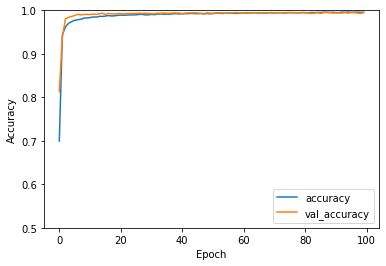

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
# plt.savefig("ann_acc.png", dpi=500)

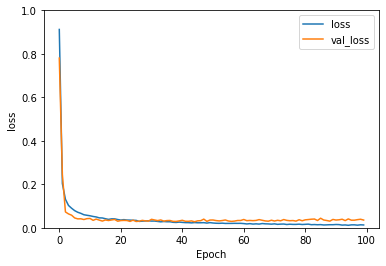

In [11]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')
# plt.savefig("ann_loss.png", dpi=500)

##Result : 
### Train accuracy: 99.57%
### Valid accuracy: 99.47%
### Test  accuracy: 99.59%
#### 可以看到訓練後期有過擬合現象。